<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Viewdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nibabel as nib
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from google.colab import widgets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cd /content/drive/MyDrive/AOCR2024/mask_bundle

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/mask_bundle


試畫mask


In [9]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import nibabel as nib

def update_plot(slice_number):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(20, 20)
    axs[0].set_title(f'Slice Number: {slice_number}')

    axs[0].imshow(mydata[:, :, slice_number], cmap='gray')
    axs[0].imshow(mymask[:, :, slice_number], cmap='Reds', alpha=0.5)
    axs[1].imshow(mydata[:, :, slice_number], cmap='gray')

    for ax in axs:
        ax.axis('off')

    plt.show()

# Load your data
nii_file = nib.load('Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628.nii')
mydata = nii_file.get_fdata()
nii_file = nib.load('Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628_label.nii')
mymask = nii_file.get_fdata()

# Create a slider widget
slider = widgets.IntSlider(
    value=27,
    min=0,
    max=89,
    step=1,
    description='Slice:'
)


# Link the slider to the update function
widgets.interactive(update_plot, slice_number=slider)


interactive(children=(IntSlider(value=27, description='Slice:', max=89), Output()), _dom_classes=('widget-inte…

(100.0, 300.0)

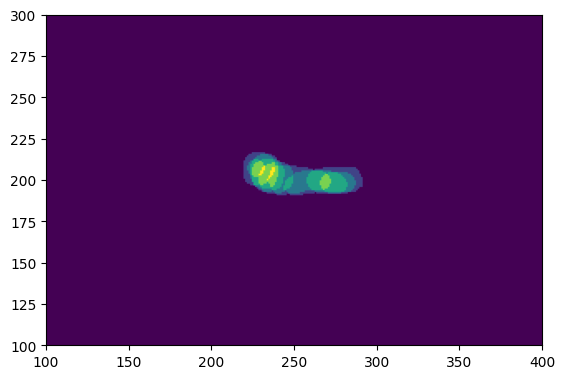

In [12]:
plt.imshow(mymask.sum(axis=2))
plt.xlim((100, 400))
plt.ylim((100, 300))

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

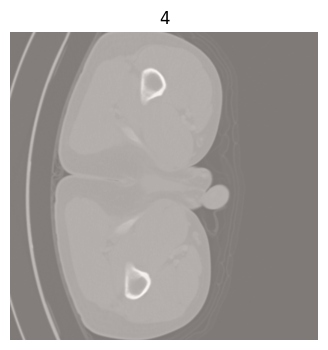

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

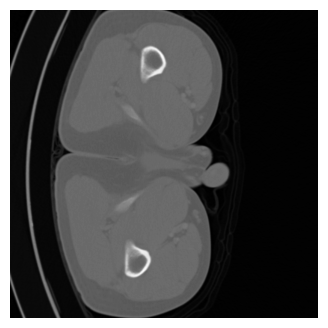

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
import time
# 读取nii文件
nii_file = nib.load('Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628.nii')
mydata = nii_file.get_fdata()
nii_file = nib.load('Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628_label.nii')
mymask = nii_file.get_fdata()


grid = widgets.Grid(1, 2)
for i in range(len(mydata)):
  with grid.output_to(0, 0):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(mydata[:, :, i], cmap='gray')
    ax.imshow(mymask[:, :, i], cmap='Reds', alpha=0.5)
    ax.axis('off')
    plt.title(f"{i}")
    grid.clear_cell()
    plt.show()
  with grid.output_to(0, 1):
    grid.clear_cell()
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(mydata[:, :, i], cmap='gray')
    ax.axis('off')
    grid.clear_cell()
    plt.show()
  time.sleep(2)

In [ ]:
import ipywidgets as widgets

slider = widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test Slider:',
    orientation='horizontal'
)
display(slider)

IntSlider(value=7, description='Test Slider:', max=10)